In [ ]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate_days = 0.0005#0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

 23%|██████████████████                                                            | 1002/4320 [00:45<02:33, 21.65it/s]

[2020-11-11 17:48:12.791253] Left to simulate: 0 days 00:00:33.200000 min or 3320 steps


 46%|████████████████████████████████████▏                                         | 2005/4320 [01:34<01:58, 19.57it/s]

[2020-11-11 17:49:01.723049] Left to simulate: 0 days 00:00:23.200000 min or 2320 steps


 69%|██████████████████████████████████████████████████████▏                       | 2999/4320 [02:33<01:22, 16.10it/s]

[2020-11-11 17:50:00.472857] Left to simulate: 0 days 00:00:13.200000 min or 1320 steps


 70%|██████████████████████████████████████████████████████▏                       | 3003/4320 [02:33<01:51, 11.79it/s]

{Timestamp('2020-09-17 10:00:00'): [<autoscalingsim.utils.deltarepr.platform_state_delta.StateDelta object at 0x000001D63C100DD8>], Timestamp('2020-09-17 10:00:00.050000'): [<autoscalingsim.utils.deltarepr.platform_state_delta.StateDelta object at 0x000001D63C130B00>], Timestamp('2020-09-17 10:00:00.060000'): [<autoscalingsim.utils.deltarepr.platform_state_delta.StateDelta object at 0x000001D63C130B38>]}


 93%|████████████████████████████████████████████████████████████████████████▎     | 4005/4320 [03:26<00:15, 20.65it/s]

[2020-11-11 17:50:53.616883] Left to simulate: 0 days 00:00:03.200000 min or 320 steps


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4293/4320 [03:39<00:01, 22.17it/s]

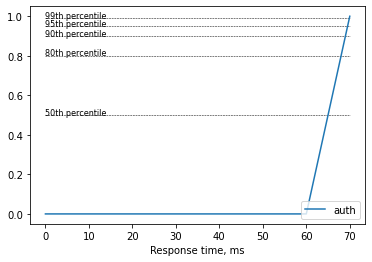

<Figure size 432x288 with 0 Axes>

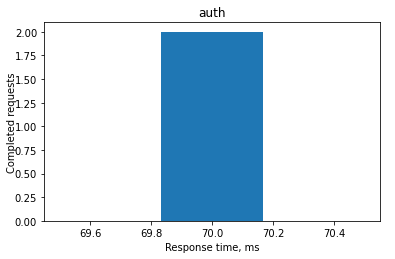

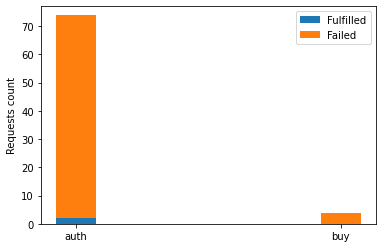

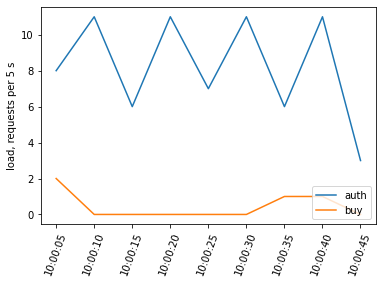

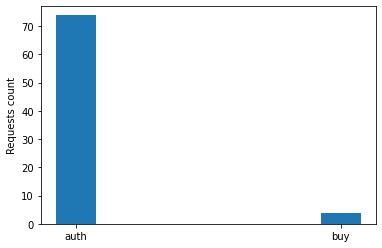

<Figure size 432x288 with 0 Axes>

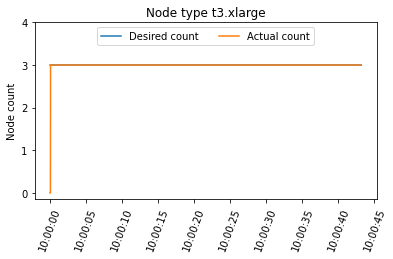

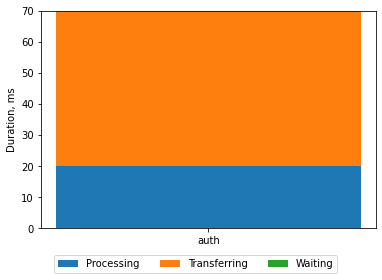

In [2]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')

In [20]:
import pandas as pd

d1 = pd.DataFrame({'datetime': [pd.Timestamp(100), pd.Timestamp(200)], 'value': [1, 2]}).set_index('datetime')
d2 = pd.DataFrame({'datetime': [pd.Timestamp(100), pd.Timestamp(300)], 'value': [1, 4]}).set_index('datetime')


d2 = d2.reindex(d1.index.union(d2.index), fill_value = 0)
d1 = d1.reindex(d2.index.union(d1.index), fill_value = 0)

d = d1 + d2
d /= 4
d[d.index >= (max(d.index) - pd.Timedelta(100))]

,value
datetime,
1970-01-01 00:00:00.000000200,0.5
1970-01-01 00:00:00.000000300,1.0
